### Example

In [1]:
import os
import librosa
import torch
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import umap
import numpy as np
from tqdm.auto import tqdm
tqdm.pandas()

/home/udesa_ubuntu/tesis/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [245]:
def wav2vec_embeddings(path_to_csv, model_name):
    feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)
    model = Wav2Vec2Model.from_pretrained(model_name)
    metadata_df = pd.read_csv(path_to_csv)
    # Create a new column to store embeddings
    metadata_df['embeddings'] = None
    # iterate over each path in "stimuli" column
    for index, row in tqdm(metadata_df.iterrows()):
        audio_file = row['stimuli']
        input_audio, sample_rate = librosa.load(audio_file, sr=16000)
        inputs = feature_extractor(input_audio, return_tensors="pt", sampling_rate=sample_rate)
        with torch.no_grad():
            outputs= model(inputs.input_values)
        embeddings = outputs.last_hidden_state
        embeddings = embeddings.mean(dim=1)
        embeddings = embeddings.squeeze().detach().numpy()

        metadata_df.at[index, 'embeddings'] = [embeddings]
                
    return metadata_df


In [251]:
path_to_csv = "/home/udesa_ubuntu/tesis/analysis/subjective_results_corrected.csv"
model = 'facebook/wav2vec2-base-960h'
metadata_df = wav2vec_embeddings(path_to_csv, model)

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
4326it [25:02,  2.88it/s]


In [252]:
metadata_df.head()

,participant_id,age,gender_participant,country,province,education,headphone_brand,stimuli,score,stimuli_group,stimuli_service,gender_stimuli,dialect,mos_pred,model,embeddings
0,ymxfxn696we9rp1tnnub3f,26,P,AR,Buenos Aires,5,samsung,/home/udesa_ubuntu/tesis/frontend/public/asset...,5.0,E2,open_srl_es_ar_female_2,F,ARG,4.201412,NISQA_TTS_v1,"[[-0.03323914, 0.014191397, 0.050381396, -0.01..."
1,ymxfxn696we9rp1tnnub3f,26,P,AR,Buenos Aires,5,samsung,/home/udesa_ubuntu/tesis/frontend/public/asset...,5.0,E2,open_srl_es_ar_female_2,F,ARG,4.755947,NISQA_TTS_v1,"[[-0.030175949, 0.006380686, -0.07789732, -0.0..."
2,9fig36z1cml41m265ckifw,25,M,AR,Buenos Aires,4,Sony,/home/udesa_ubuntu/tesis/frontend/public/asset...,5.0,E2,open_srl_es_ar_female_2,F,ARG,4.338622,NISQA_TTS_v1,"[[-0.042567268, -0.004609356, -0.078064285, -0..."
3,vj735xlt2yj805wyn5rimq,59,F,AR,Buenos Aires,2,NaN,/home/udesa_ubuntu/tesis/frontend/public/asset...,4.0,E2,open_srl_es_ar_female_2,F,ARG,4.223487,NISQA_TTS_v1,"[[-0.06106445, 0.0152936615, -0.009794445, -0...."
4,vj735xlt2yj805wyn5rimq,59,F,AR,Buenos Aires,2,NaN,/home/udesa_ubuntu/tesis/frontend/public/asset...,4.0,E2,open_srl_es_ar_female_2,F,ARG,3.404321,NISQA_TTS_v1,"[[-0.034011673, 0.002930334, -0.012123391, -0...."


In [253]:
metadata_df["embeddings"] = metadata_df["embeddings"].apply(lambda x: x[0])

# U-MAP

In [254]:
#Create a numpy array with the features and project them to 2D using UMAP:
X = np.stack(metadata_df['embeddings'])
print('Projecting to 2D with UMAP')
projector = umap.UMAP()
projected = projector.fit_transform(X)
metadata_df['X'] = projected[:,0]
metadata_df['Y'] = projected[:,1]

Projecting to 2D with UMAP


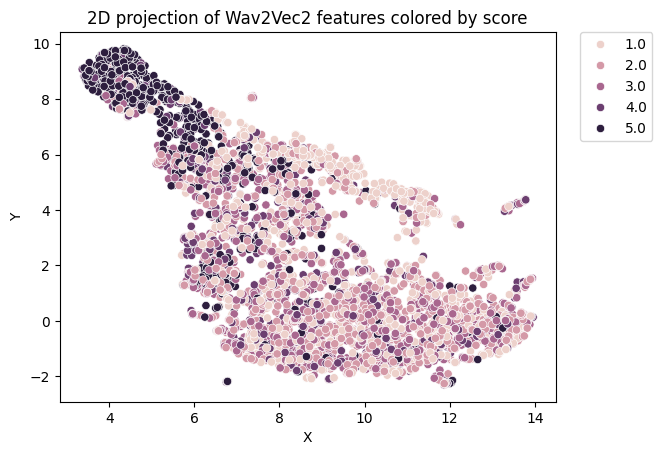

In [255]:
plt.title('2D projection of Wav2Vec2 features colored by score')
sns.scatterplot(data=metadata_df,x='X',y='Y',hue='score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

In [256]:
# save pandas dataframe to csv
metadata_df.to_csv('wav2vec2-base-960h.csv', index=False)

# wav2vec-base

In [257]:
path_to_csv = "/home/udesa_ubuntu/tesis/analysis/subjective_results_corrected.csv"
model = 'facebook/wav2vec2-base'
metadata_df_base = wav2vec_embeddings(path_to_csv, model)
metadata_df_base["embeddings"] = metadata_df_base["embeddings"].apply(lambda x: x[0])
metadata_df_base.head()

/home/udesa_ubuntu/tesis/.venv/lib/python3.9/site-packages/transformers/configuration_utils.py:365: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
4326it [25:35,  2.82it/s]


,participant_id,age,gender_participant,country,province,education,headphone_brand,stimuli,score,stimuli_group,stimuli_service,gender_stimuli,dialect,mos_pred,model,embeddings
0,ymxfxn696we9rp1tnnub3f,26,P,AR,Buenos Aires,5,samsung,/home/udesa_ubuntu/tesis/frontend/public/asset...,5.0,E2,open_srl_es_ar_female_2,F,ARG,4.201412,NISQA_TTS_v1,"[0.15312731, 0.08109648, -0.10660832, -0.00431..."
1,ymxfxn696we9rp1tnnub3f,26,P,AR,Buenos Aires,5,samsung,/home/udesa_ubuntu/tesis/frontend/public/asset...,5.0,E2,open_srl_es_ar_female_2,F,ARG,4.755947,NISQA_TTS_v1,"[0.040599525, 0.09763612, -0.019022152, -0.002..."
2,9fig36z1cml41m265ckifw,25,M,AR,Buenos Aires,4,Sony,/home/udesa_ubuntu/tesis/frontend/public/asset...,5.0,E2,open_srl_es_ar_female_2,F,ARG,4.338622,NISQA_TTS_v1,"[0.123369664, 0.102499016, -0.08867811, 0.0039..."
3,vj735xlt2yj805wyn5rimq,59,F,AR,Buenos Aires,2,NaN,/home/udesa_ubuntu/tesis/frontend/public/asset...,4.0,E2,open_srl_es_ar_female_2,F,ARG,4.223487,NISQA_TTS_v1,"[0.07791688, 0.10479831, -0.007728797, 0.03852..."
4,vj735xlt2yj805wyn5rimq,59,F,AR,Buenos Aires,2,NaN,/home/udesa_ubuntu/tesis/frontend/public/asset...,4.0,E2,open_srl_es_ar_female_2,F,ARG,3.404321,NISQA_TTS_v1,"[0.09560414, 0.097589806, -0.048718706, 0.0200..."


In [258]:
#Create a numpy array with the features and project them to 2D using UMAP:
X = np.stack(metadata_df['embeddings'])
print('Projecting to 2D with UMAP')
projector = umap.UMAP()
projected = projector.fit_transform(X)
metadata_df['X'] = projected[:,0]
metadata_df['Y'] = projected[:,1]

Projecting to 2D with UMAP


In [263]:
metadata_df.head()

,participant_id,age,gender_participant,country,province,education,headphone_brand,stimuli,score,stimuli_group,stimuli_service,gender_stimuli,dialect,mos_pred,model,embeddings,X,Y
0,ymxfxn696we9rp1tnnub3f,26,P,AR,Buenos Aires,5,samsung,/home/udesa_ubuntu/tesis/frontend/public/asset...,5.0,E2,open_srl_es_ar_female_2,F,ARG,4.201412,NISQA_TTS_v1,"[-0.03323914, 0.014191397, 0.050381396, -0.010...",4.670205,0.966779
1,ymxfxn696we9rp1tnnub3f,26,P,AR,Buenos Aires,5,samsung,/home/udesa_ubuntu/tesis/frontend/public/asset...,5.0,E2,open_srl_es_ar_female_2,F,ARG,4.755947,NISQA_TTS_v1,"[-0.030175949, 0.006380686, -0.07789732, -0.04...",3.635737,1.703282
2,9fig36z1cml41m265ckifw,25,M,AR,Buenos Aires,4,Sony,/home/udesa_ubuntu/tesis/frontend/public/asset...,5.0,E2,open_srl_es_ar_female_2,F,ARG,4.338622,NISQA_TTS_v1,"[-0.042567268, -0.004609356, -0.078064285, -0....",4.558440,0.258265
3,vj735xlt2yj805wyn5rimq,59,F,AR,Buenos Aires,2,NaN,/home/udesa_ubuntu/tesis/frontend/public/asset...,4.0,E2,open_srl_es_ar_female_2,F,ARG,4.223487,NISQA_TTS_v1,"[-0.06106445, 0.0152936615, -0.009794445, -0.0...",4.493123,0.207002
4,vj735xlt2yj805wyn5rimq,59,F,AR,Buenos Aires,2,NaN,/home/udesa_ubuntu/tesis/frontend/public/asset...,4.0,E2,open_srl_es_ar_female_2,F,ARG,3.404321,NISQA_TTS_v1,"[-0.034011673, 0.002930334, -0.012123391, -0.0...",5.327507,-0.018003


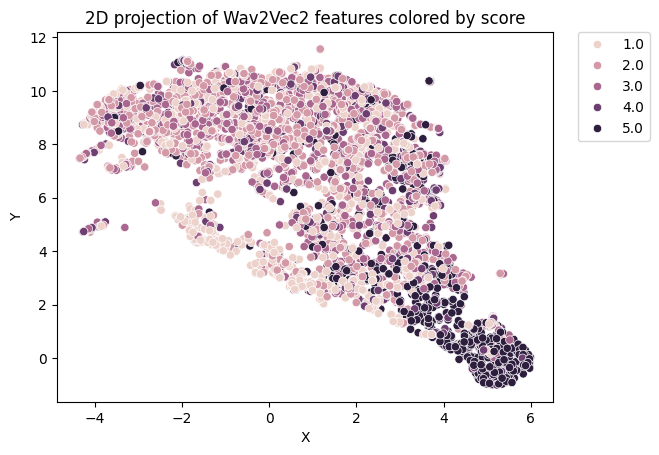

In [267]:
plt.title('2D projection of Wav2Vec2 features colored by score')
sns.scatterplot(data=metadata_df,x='X',y='Y',hue='score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

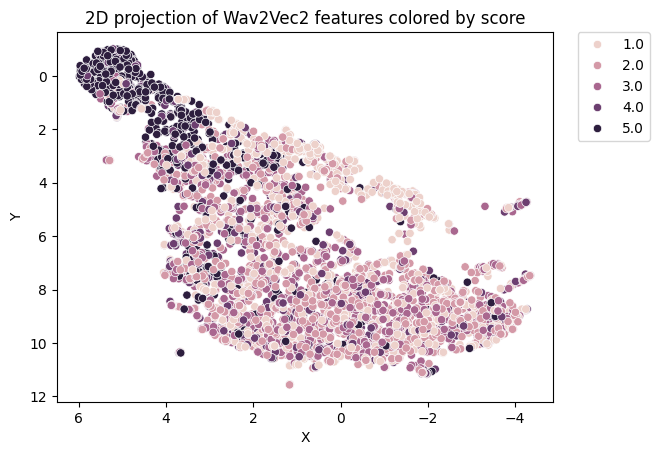

In [266]:
plt.title('2D projection of Wav2Vec2 features colored by score')
sns.scatterplot(data=metadata_df, x='X', y='Y', hue='score')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

In [262]:
# to_pickle()
metadata_df.to_pickle('wav2vec2-base.pkl')
